# Photon Transfer Curve testing
This notebook shows how to use the LSST Butler to display and analyze raw test stand data. We'll start with how to run and isolate specific ISR tasks, then start to look at raw pixel values at an amp by amp basis. This is mostly a copy of Brian Stalder's notebook:

https://github.com/bstalder/notebooks/blob/master/eotesting/eotestanalysis_ptc.ipynb

based on Robert Lupton's notebook:

https://github.com/RobertLuptonTheGood/notebooks/blob/master/Demos/Looking%20at%20Teststand%20Data.ipynb

First, let's do some importing and setup.

In [1]:
import numpy as np
import lsst.daf.persistence as dafPersist
import lsst.ip.isr.assembleCcdTask as assemble   # force an import of pcaPsfDeterminer.py (which selects ds9) (DM-13432)
import lsst.afw.cameraGeom.utils as cameraGeomUtils
import lsst.afw.display as afwDisplay
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from scipy import stats
from astropy.stats import SigmaClip

%matplotlib inline 
#%matplotlib notebook
#%config InlineBackend.figure_format = 'retina'

#%matplotlib qt
#%gui qt

I've chosen to use matplotlib, but can probably use ds9 or firefly instead.

In [2]:
afwDisplay.setDefaultBackend("matplotlib" if True else "ds9")


Point at the pre-ingested repository.  This one is some ComCam TS8 data.  Currently, the only keys are run, visit, detectorName.  There is currently just a 1-1 formula to translate MJD of the exposure to that visit number, or more useful vice-versa is:  $MJD = 55197 + visitnum*100000$.  In the future we'll have more keys in the butler in order to better ID exposures!

In [3]:
dataPath = "/project/shared/comCam"
#dataPath = "/datasets/comCam/repo/rtm5" # This points to rtm5 TS8 data

butler = dafPersist.Butler(dataPath)
print("Available runs: %s" % (" ".join(butler.queryMetadata('raw', ['run']))))  # available runs


Available runs: -1 10578 10579 10580 10581 10589 10591 10592 10593 10594


Another way to get a dataId would be to look at the various other metadata, but is not well documented what is available...  at least imageType (FLAT, BIAS, DARK), and wavelength (monochromator setting).

In [4]:
print(butler.queryMetadata('raw',['visit','exptime','wavelength'],imageType='FLAT',testType='FLAT',run=10594))
print(butler.queryMetadata('raw',['visit','exptime'],imageType='BIAS',testType='FLAT',run=10594))
ptc_visits=butler.queryMetadata('raw', ['visit'], imageType='FLAT', testType='FLAT',run=10594)
bias_visits=butler.queryMetadata('raw', ['visit'], imageType='BIAS', testType='FLAT',run=10594)
print(len(ptc_visits))
print(len(bias_visits))

[(201904190327517, 1.0, 675), (201904190328004, 1.0, 675), (201904190328195, 1.3, 675), (201904190328276, 1.3, 675), (201904190328455, 1.8, 675), (201904190328534, 1.8, 675), (201904190329124, 2.4, 675), (201904190329215, 2.4, 675), (201904190329434, 3.2, 675), (201904190329531, 3.2, 675), (201904190330129, 4.2, 675), (201904190330240, 4.2, 675), (201904190330473, 5.6, 675), (201904190330595, 5.6, 675), (201904190331239, 7.5, 675), (201904190331373, 7.5, 675), (201904190332016, 10.0, 675), (201904190332181, 10.0, 675), (201904190332450, 13.0, 675), (201904190333041, 13.0, 675), (201904190333340, 18.0, 675), (201904190333587, 18.0, 675), (201904190334438, 24.0, 675), (201904190335144, 24.0, 675), (201904190335561, 32.0, 675), (201904190336346, 32.0, 675), (201904190337239, 42.0, 675), (201904190338122, 42.0, 675), (201904190339115, 56.0, 675), (201904190340145, 56.0, 675), (201904190341292, 75.0, 675), (201904190342509, 75.0, 675), (201904190344223, 80.0, 675), (201904190345481, 80.0, 6

The camera description has all the various particulars of the raft-level data (defined under the comcam obs package).
https://github.com/lsst/obs_comCam

In [5]:
camera = butler.get("camera")

For looking at a specific CCD, can do a butler.get:

In [6]:
ptc_visit = ptc_visits[-1]  # this is the last flat in the PTC run
CCD = 'S11'
dataId = dict(visit=ptc_visit, detectorName=CCD) # Use this for ComCam
#dataId = dict(visit=ptc_visit, ccd=CCD) # Use this for LSSTCam
print(dataId)
print(butler.queryMetadata('raw',['run','imageType','exptime'],dataId))
raw = butler.get('raw',dataId)
# get() currently throws a "FILTPOS key not found in header (assuming NONE)" error
# it's safe, but annoying when getting many images as in this notebook

{'visit': 201904190456303, 'detectorName': 'S11'}
[('10594', 'FLAT', 275.0)]


FILTPOS key not found in header (assuming NONE)


Okay, now let's try to get a PTC plot.  First let's define a set (bias, flat1, flat2) of exposures.

In [7]:
dataId0 = dict(visit=bias_visits[0], detectorName=CCD) # bias
dataId1 = dict(visit=ptc_visits[-1], detectorName=CCD) # flat1
dataId2 = dict(visit=ptc_visits[-2], detectorName=CCD) # flat2

bias = butler.get('raw', dataId0)
flat1 = butler.get('raw', dataId1)
flat2 = butler.get('raw', dataId2)

FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)


Then there are multiple ways to get at the amplifiers.  First is to use the camera definition, another way is to use the raw_amp butler object.

In [8]:
amp=bias.getDetector()[8]  # pick the 9th amplifier

print(np.mean( (flat1[amp.getBBox()].image.array-bias[amp.getBBox()].image.array) ) )
print(np.std( (flat1[amp.getBBox()].image.array-flat2[amp.getBBox()].image.array) )**2)

# or (potentially) alternatively, I can't get this method to work correctly

# bias_amp = butler.get("raw_amp", run=4625, visit=bias_visits[0], detectorName=CCD, channel=8)
# flat1_amp = butler.get("raw_amp", run=4625, visit=ptc_visits[-1], detectorName=CCD, channel=8)
# flat2_amp = butler.get("raw_amp", run=4625, visit=ptc_visits[-2], detectorName=CCD, channel=8)
# ampbox=bias_amp.getBBox()
# print(np.mean( (flat1_amp[ampbox].image.array-bias_amp[ampbox].image.array) ) )
# print(np.std( (flat1_amp[ampbox].image.array-flat2_amp[ampbox].image.array) )**2)


146155.5
50036.97143936157


Ok so that was mean (bias subtracted) and variance (of difference of 2 flats) of a single run of exposures, for a single amplifier. Let's set up some useful functions. This one gets all the data for an amplifier, trims the overscan, sigma-clips the data, and returns the signal and variance of all the visits in the run.

In [9]:
def getAmpData(ampNum, CCD, sig):
    amp=detector.getDetector()[ampNum]  # pick the nth amplifier

    signal = []
    variance = []

    for i in range(0,len(ptc_visits),2):
        # Collect image data
        dataIdbias = dict(visit=bias_visits[0]) # bias
        dataIdflat1 = dict(visit=ptc_visits[i]) # flat1
        dataIdflat2 = dict(visit=ptc_visits[i+1]) # flat2

        bias = butler.get('raw', visit=dataIdbias["visit"], detectorName=CCD)
        flat1 = butler.get('raw', visit=dataIdflat1["visit"], detectorName=CCD)
        flat2 = butler.get('raw', visit=dataIdflat2["visit"], detectorName=CCD)
        
        # Trim pre-/overscan regions
        a = assemble.AssembleCcdTask()
        biasTrim = a.assembleCcd(bias)
        flat1Trim = a.assembleCcd(flat1)
        flat2Trim = a.assembleCcd(flat2)
        
        # Sigma clip
        flatData1 = flat1Trim[amp.getBBox()].image.array.flatten()
        flatData2 = flat2Trim[amp.getBBox()].image.array.flatten()
        flatBias = biasTrim[amp.getBBox()].image.array.flatten()
        
        sigclip = SigmaClip(sigma=sig)
        clipped1 = sigclip(flatData1)
        clipped2 = sigclip(flatData2)
        mask = np.ma.mask_or(clipped1.mask, clipped2.mask)
        
        clippedBias = np.array(flatBias[~mask])
        clippedData = np.array(flatData1[~mask])
        clippedDiff = np.array(np.subtract(flatData2[~mask],flatData1[~mask]))
        
        # Add values to signal, variance
        signal.append(np.mean(np.subtract(clippedData, clippedBias)))
        variance.append(np.std(clippedDiff)**2)
        #print("Finished exposure %i" %(i/2+1))
    variance = np.divide(variance,2)
        
    return (signal, variance)

This one plots the PTC along with a linear fit line. The fit line currently only uses the lower 60% of the data, which can be set manually, but should have a more rigorous definition.

In [10]:
def plotPTC(ampNum, signal, variance, axes):
    axes[ampNum].scatter(signal, variance)
    
    
    # Use regression to actually find gain
    # Not including obviously saturated exposures, including lower 60% of signal
    slope, intercept, _, _, _ = stats.linregress(signal[signal<(0.6*max(signal))],
                                                 variance[np.where(signal<(0.6*max(signal)))])

    xmax = signal[-1]
    axes[ampNum].plot([0, xmax], [intercept, slope*xmax+intercept], 'r')
    axes[ampNum].set_title("{0:.2f} e-/ADU".format(slope))
    
    return (slope, intercept)

Let's try to get data for every amplifier now (takes a few minutes):

In [11]:
detector = butler.get('raw', dataId0)

signal = np.zeros((16,int(len(ptc_visits)/2)))
variance = np.zeros((16,int(len(ptc_visits)/2)))

for i in range(16):
    signal[i], variance[i] = getAmpData(i,'S11',3.5)
    print("Finished amplifier %i" %(i+1))

FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 1


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 2


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 3


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 4


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 5


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 6


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 7


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 8


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 9


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 10


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 11


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 12


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 13


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 14


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 15


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 16


If we don't want to run through the collecting data process every single time we want to look at the data, we can save it:

In [12]:
np.save('./signal11.npy', signal)
np.save('./variance11.npy', variance)

And then recall it later with this:

In [13]:
signal = np.load('./signal11.npy')
variance = np.load('./variance11.npy')

Now we can plot each PTC in a CCD by doing:

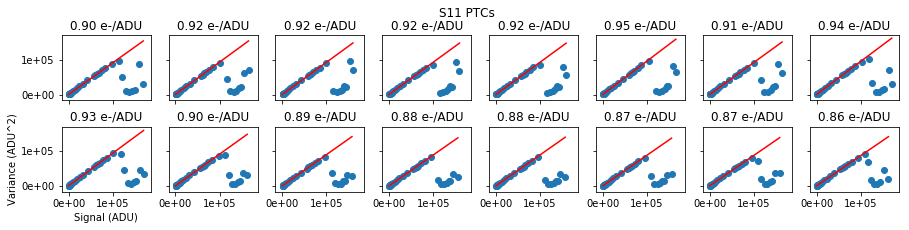

In [14]:
myFig, axes = plt.subplots(2, 8, sharex='all', sharey='all', figsize=(15,3))
axes = np.reshape(axes, 16)
axes[8].set_xlabel('Signal (ADU)')
axes[8].set_ylabel('Variance (ADU^2)')
axes[0].get_xaxis().set_major_formatter(mtick.FormatStrFormatter('%.e')) # I don't really like how this looks
axes[0].get_yaxis().set_major_formatter(mtick.FormatStrFormatter('%.e'))
plt.subplots_adjust(hspace=0.4, top=0.85)
myFig.suptitle(CCD+" PTCs\n")

gains=[] # If we want to save the gain values for later

for i in range(16):
    slope, intercept = plotPTC(i, signal[i], variance[i], axes)
    gains.append(slope)

Note this is not the actual locations of each amplifier on the CCD.

Let's take a closer look at amplifier 9:

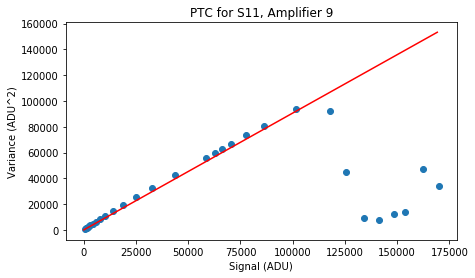

In [16]:
fig = plt.figure(figsize=(7,4))
plt.scatter(signal[8], variance[8])
plt.title("PTC for S11, Amplifier 9")
plt.xlabel("Signal (ADU)")
plt.ylabel("Variance (ADU^2)")
plt.plot([0, signal[0,-1]], [0, 0.906*signal[0,-1]], 'r')

What is the bit curling up for the last few points? Does it affect any other data?
Maybe we want to change how much data the fit line takes in as well, if it is skewed toward the higher points.

This is how I decided on using the lower 60% of the data. All I did was see how much data I could include without the standard error jumping up too high.

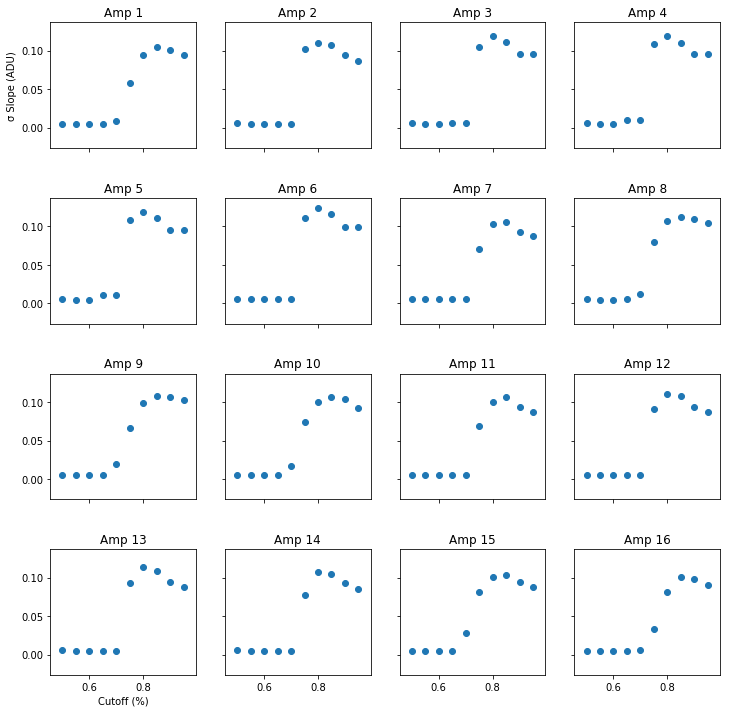

In [17]:
#from sklearn.linear_model import LinearRegression
#from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

newFig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(12,12))
plt.subplots_adjust(hspace=0.4)
axes = np.reshape(axes,16)
axes[0].set_ylabel("\u03C3 Slope (ADU)")
axes[12].set_xlabel('Cutoff (%)')

signal = np.load("./signal11.npy")
variance = np.load("./variance11.npy")

for i in range(16):
    axes[i].set_title("Amp {}".format(i+1))
    
    cutoffs = np.array(range(50,100,5))
    cutoffs = np.divide(cutoffs,100)
    errs = []

    for cut in cutoffs:
        # See what index of "signal" corresponds to 60% of the max value
        index = -1
        while signal[i,index] >= cut*max(signal[i]):
            index -= 1
        
        # Find the standard error if we include that much data
        if index == -1:
            slope, intercept, _, _, std_err = stats.linregress(signal, variance)

        else:
            slope, intercept, _, _, std_err = stats.linregress(signal[i,0:index+1], variance[i,0:index+1])

        errs.append(std_err)

    axes[i].scatter(cutoffs,errs)

This is around 60ish% before jumping up, but like I said, it could use a more precise definition.

If we want to get data for the entire raft, we can run this cell (in an hour or two). I don't know how to supress the "FILTPOS key not found in header (assuming NONE)" warning, so there will be a large output for ComCam data.

In [20]:
CCDs = ['S00', 'S01', 'S02', 'S10', 'S11', 'S12', 'S20', 'S21', 'S22']
gains = []

for c in CCDs:
    myFig, axes = plt.subplots(2, 8, sharex='all', sharey='all', figsize=(15,3))
    axes = np.reshape(axes, 16)
    #axes[0].axis([0,200000,0,300000])
    axes[8].set_xlabel('Signal (ADU)')
    axes[8].set_ylabel('Variance (ADU^2)')
    axes[0].get_xaxis().set_major_formatter(mtick.FormatStrFormatter('%.e'))
    axes[0].get_yaxis().set_major_formatter(mtick.FormatStrFormatter('%.e'))
    plt.subplots_adjust(hspace=0.4, top=0.85)
    myFig.suptitle(c+" PTCs at 675nm\n")
    
    dataId0 = dict(visit=ptc_visits[0], detectorName=c) # "detectorName" is "ccd" on LSSTCam files
    detector = butler.get('raw', dataId0)
    
    signal = np.zeros((16,int(len(ptc_visits)/2)))
    variance = np.zeros((16,int(len(ptc_visits)/2)))

    for i in range(16):
        signal[i], variance[i] = getAmpData(i,c,5)
        slope, intercept = plotPTC(i, signal[i], variance[i], axes)
        print("Finished amplifier %i" %(i+1))
        gains.append(slope)
        
    # Save the data so we don't have to run this cell multiple times
    loc = "./"
    PTCFile = loc + c + "PTCs.png"
    myFig.savefig(PTCFile, format='png', dpi=300)
    
    sigFile = loc + "signal" + c + ".npy"
    varFile = loc + "variance" + c + ".npy"
    
    np.save(sigFile, signal)
    np.save(varFile, variance)
            
    print("Finished CCD " + c)
    myFig.clf()

# Save the gains
np.save(loc + 'gains.npy',gains)

FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 1


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 2


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 3


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 4


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 5


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 6


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 7


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 8


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 9


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 10


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 11


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 12


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 13


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 14


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 15


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 16
Finished CCD S00


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 1


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 2


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 3


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 4


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 5


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 6


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 7


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 8


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 9


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 10


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 11


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 12


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 13


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 14


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 15


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 16
Finished CCD S01


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 1


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 2


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 3


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 4


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 5


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 6


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 7


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 8


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 9


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 10


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 11


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 12


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 13


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 14


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 15


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 16
Finished CCD S02


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 1


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 2


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 3


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 4


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 5


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 6


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 7


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 8


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 9


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 10


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 11


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 12


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 13


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 14


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 15


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 16
Finished CCD S10


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 1


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 2


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 3


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 4


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 5


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 6


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 7


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 8


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 9


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 10


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 11


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 12


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 13


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 14


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 15


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 16
Finished CCD S11


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 1


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 2


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 3


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 4


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 5


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 6


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 7


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 8


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 9


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 10


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 11


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 12


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 13


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 14


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 15


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 16
Finished CCD S12


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 1


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 2


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 3


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 4


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 5


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 6


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 7


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 8


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 9


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 10


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 11


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 12


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 13


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 14


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 15


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 16
Finished CCD S20


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 1


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 2


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 3


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 4


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 5


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 6


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 7


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 8


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 9


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 10


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 11


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 12


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 13


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 14


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 15


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 16
Finished CCD S21


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 1


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 2


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 3


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 4


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 5


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 6


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 7


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 8


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 9


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 10


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 11


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 12


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 13


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 14


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 15


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assumin

Finished amplifier 16
Finished CCD S22


<Figure size 1080x216 with 0 Axes>

<Figure size 1080x216 with 0 Axes>

<Figure size 1080x216 with 0 Axes>

<Figure size 1080x216 with 0 Axes>

<Figure size 1080x216 with 0 Axes>

<Figure size 1080x216 with 0 Axes>

<Figure size 1080x216 with 0 Axes>

<Figure size 1080x216 with 0 Axes>

<Figure size 1080x216 with 0 Axes>

Then plot all the PTCs:

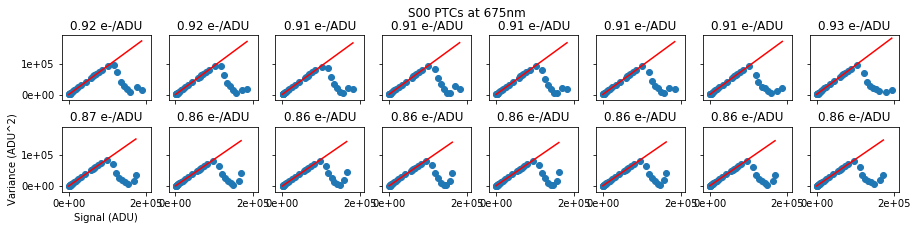

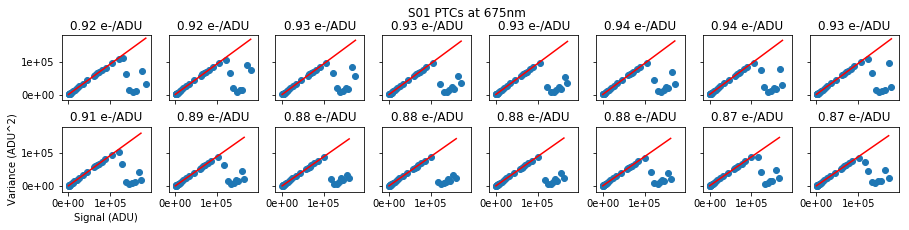

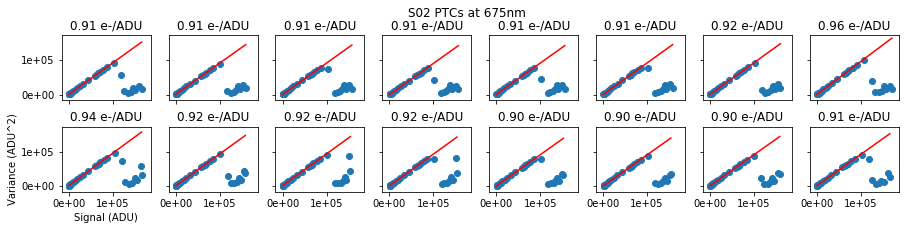

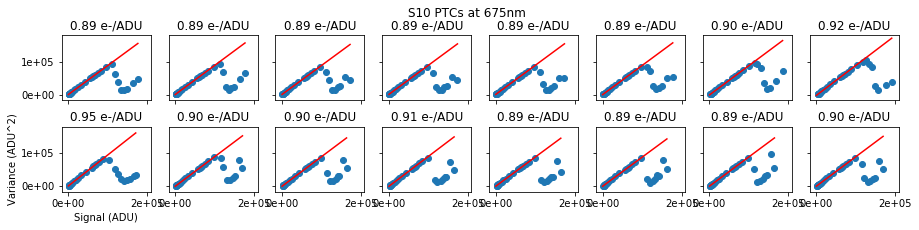

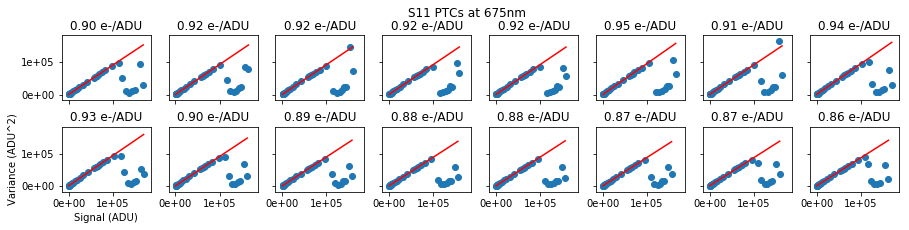

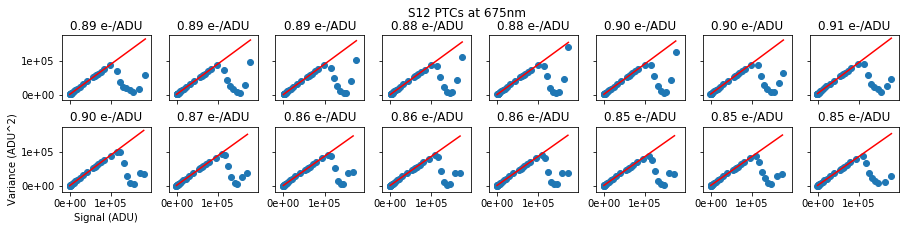

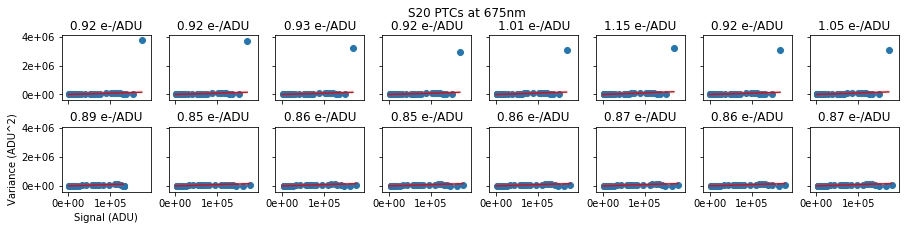

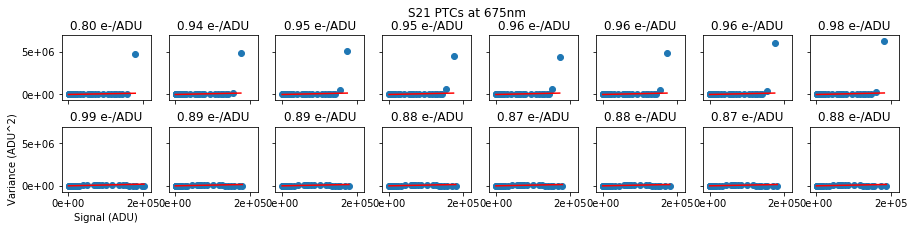

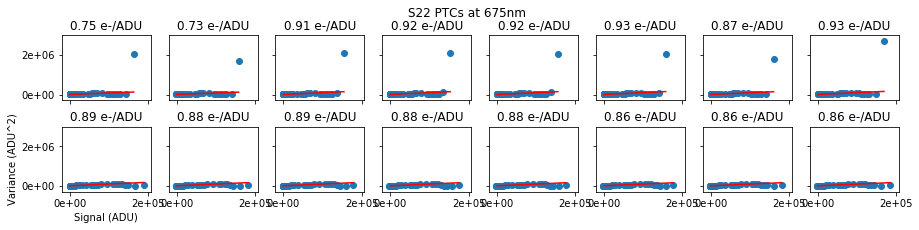

In [21]:
gains = []
for c in CCDs:
    myFig, axes = plt.subplots(2, 8, sharex='all', sharey='all', figsize=(15,3))
    axes = np.reshape(axes, 16)
    #axes[0].axis([0,200000,0,150000])
    axes[8].set_xlabel('Signal (ADU)')
    axes[8].set_ylabel('Variance (ADU^2)')
    axes[0].get_xaxis().set_major_formatter(mtick.FormatStrFormatter('%.e'))
    axes[0].get_yaxis().set_major_formatter(mtick.FormatStrFormatter('%.e'))
    plt.subplots_adjust(hspace=0.4, top=0.85)
    myFig.suptitle(c+" PTCs at 675nm\n")
    
    sigFile = "./signal" + c + ".npy"
    varFile = "./variance" + c + ".npy"
    
    signal = np.load(sigFile)
    variance = np.load(varFile)

    for i in range(16):
        slope, intercept = plotPTC(i, signal[i], variance[i], axes)
        gains.append(slope)
        
    PTCFile = "./" + c + "PTCs.png"
    myFig.savefig(PTCFile, format='png', dpi=300)

Finally, we can make a plot of all the gains in the raft:

Text(20, 5, 'S22')

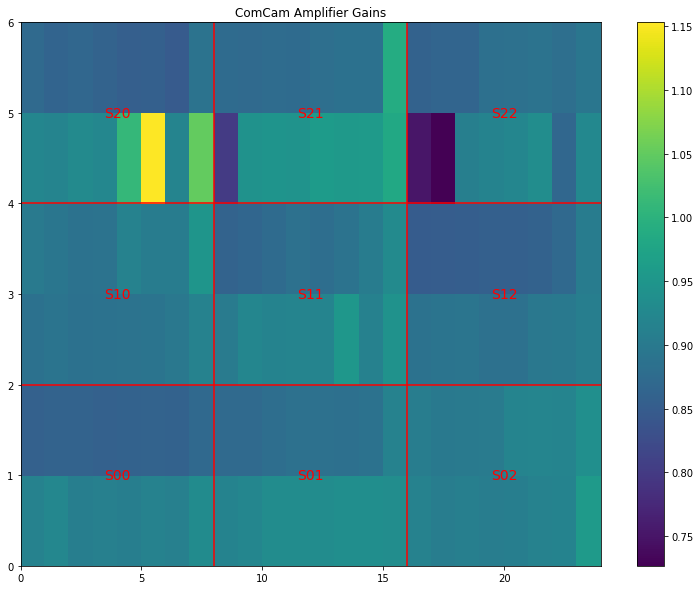

In [22]:
gains = np.load('./gains.npy')

# Put the gains in the correct places on the raft, since they're currently ordered by amp
gains = np.reshape(gains, (18,8))
for i in range(1,19,2):
    gains[i] = np.flip(gains[i])
order = [0,2,4,1,3,5,6,8,10,7,9,11,12,14,16,13,15,17]
gains = gains[order]
gains = gains.reshape(6,24)
# This could potentially be the wrong order - the top two rows might need to be on the bottom and vice versa

fig = plt.figure(figsize=(13,10))
plt.pcolor(gains)#, vmin=0.8, vmax=1.05)
plt.colorbar()
plt.title("ComCam Amplifier Gains")

# Show CCDs on top of plot
for i in range(1,3):
    plt.axhline(y=2*i,c='r')
    plt.axvline(x=8*i,c='r')
    
kwargs = {"horizontalalignment":"center", "verticalalignment":"center","color":'r',"fontsize":14}
plt.text(4,1,"S00",**kwargs)
plt.text(12,1,"S01",**kwargs)
plt.text(20,1,"S02",**kwargs)
plt.text(4,3,"S10",**kwargs)
plt.text(12,3,"S11",**kwargs)
plt.text(20,3,"S12",**kwargs)
plt.text(4,5,"S20",**kwargs)
plt.text(12,5,"S21",**kwargs)
plt.text(20,5,"S22",**kwargs)

And save this file if we want to:

In [23]:
PTCFile = "./gains.png"
fig.savefig(PTCFile, format='png', dpi=300)